# Load & Group Tracks

In [1]:
setwd("~/Upd-Germline-Genomics")

In [2]:
source("_targets.R")
library(matrixStats)
library(GenomicRanges)

tar_load(chic.tile.diameter_1000_chr)
tar_load(repli.peaks_chr)
tar_load(repli.static.timing.peaks)
tar_load(repli.timing_Germline_chr)
tar_load(repli.timing_Somatic_chr)
tar_load(repli.timing_Kc167_chr)
tar_load(repli.timing_S2_chr)

feature_width <- 10
Y <- tibble(
  seqnames = as.factor(seqnames(chic.tile.diameter_1000_chr)),
  as_tibble(
    sapply(
      repli.peaks_chr[-7],
      \(gr) tibble(
        m = as.list(findOverlaps(chic.tile.diameter_1000_chr, gr)),
        n = rep(NA, length(chic.tile.diameter_1000_chr)) %>%
          replace(
            which(sapply(m, length) != 0),
            names(gr)[sapply(subset(m, sapply(m, length) != 0), \(v) head(v, 1))]
          )
      )$n
    )
  ),
  tibble(
    m = as.list(findOverlaps(chic.tile.diameter_1000_chr, repli.static.timing.peaks)),
    Static = rep(NA, length(chic.tile.diameter_1000_chr)) %>%
      replace(
        which(sapply(m, length) != 0),
        as.character(sapply(subset(m, sapply(m, length) != 0), \(v) head(v, 1)))
      )
  )["Static"],
  GSC = repli.timing_Germline_chr$score,
  CySC = repli.timing_Somatic_chr$score,
  Kc167 = repli.timing_Kc167_chr$score,
  S2 = repli.timing_S2_chr$score,
)
Y <- tibble(
  Y[1:8],
  i = c(
    TRUE,
    rowSums(abs(colDiffs(matrix(as.numeric(is.na(as.matrix(Y[2:8]))), nrow = nrow(Y))))) != 0
  ) %>%
    cumsum(),
  bg_group = Y[2:8] %>%
    split(i) %>%
    sapply(
      \(df) if (all(is.na(as.matrix(df)))) {
        factor(floor((seq(nrow(df)) - 1) / feature_width) * feature_width)
      } else {
        factor(rep("0", nrow(df)))
      }
    ) %>%
    do.call(c, .),
  Y[9:ncol(Y)],
) %>%
  group_by(
    seqnames, Germline_Somatic, Germline_Kc167, Germline_S2,
    Somatic_Kc167, Somatic_S2, Kc167_S2, Static, i, bg_group
  )

Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownam

# Create Individuals (10 kb cuts or Peaks) and Apply Mean of Region

In [3]:
indiv <- tibble(
  Y[1:8],
  rowname = simplify2array(group_map(Y, \(x, y) length(x$GSC))) %>%
    rep(seq_along(.), .),
  start = start(chic.tile.diameter_1000_chr), end = end(chic.tile.diameter_1000_chr),
  Y[11:14],
) %>%
  group_by(seqnames, rowname) %>%
  summarise(
    n = length(GSC),
    start = min(start),
    end = max(end),
    across(c(GSC, CySC, Kc167, S2), mean),
    Static = as.numeric(!is.na(Static[1])),
    # Stem = any(!is.na(c(Germline_Kc167, Germline_S2)) & any(!is.na(c(Somatic_Kc167, Somatic_S2)))),
    # GSC_Diff = any(!is.na(c(Germline_Somatic, Germline_Kc167, Germline_S2))),
    # Kc_Diff = any(!is.na(c(Germline_Kc167, Kc167_S2))),
    Stem = min(mean(!is.na(c(Germline_Kc167, Germline_S2))), mean(!is.na(c(Somatic_Kc167, Somatic_S2)))),
    GSC_Diff = min(mean(!is.na(Germline_Somatic)), mean(!is.na(c(Germline_Kc167, Germline_S2)))),
    Kc_Diff = min(mean(!is.na(Germline_Kc167)), mean(!is.na(Kc167_S2))),
    Grand_Mean = 1,
    .groups = "drop"
  )
ov <- findOverlaps(
  GRanges(indiv$seqnames, IRanges(indiv$start, indiv$end)) %>%
    GenomicRanges::resize(width = width(.) + 10000, fix = "center"),
  chic.tile.diameter_1000_chr
)
indiv[c("GSC", "CySC", "Kc167", "S2")] <- sapply(
  list(
    repli.timing_Germline_chr,
    repli.timing_Somatic_chr,
    repli.timing_Kc167_chr,
    repli.timing_S2_chr
  ),
  \(tr) split(
    tr$score[to(ov)],
    from(ov)
  ) %>%
    sapply(mean)
)

# Heatmap Uniform Windows With 50% Step Size

In [4]:
windows_gr <- unlist(slidingWindows(GRanges(names(chr.lengths), IRanges(1, width = chr.lengths)), 10*1000, 5*1000))
windows <- tibble(
  chr = as.factor(seqnames(windows_gr)),
  start = start(windows_gr),
  end = end(windows_gr),
  mid = mid(windows_gr),
  width = width(windows_gr),
  individuals = as.list(findOverlaps(windows_gr, GRanges(indiv$seqnames, IRanges(indiv$start, indiv$end))))
) %>%
  rowwise() %>%
  mutate(
    weights = IRanges(indiv$start[individuals], indiv$end[individuals]) %>%
      restrict(start, end) %>%
      width() %>%
      `/`(sum(.)) %>%
      list(),
    indiv[individuals, c("GSC", "CySC", "Kc167", "S2", "Static", "Stem", "GSC_Diff", "Kc_Diff")] %>%
      summarise(
        across(
          c(
            GSC, CySC, Kc167, S2,
            Static_Early = Static, 
            GSC_CySC_Early = Stem,
            GSC_CySC_Late = Stem,
            GSC_Early = GSC_Diff,
            CySC_Early = GSC_Diff,
            Kc167_Early = Kc_Diff,
            Kc167_Late = Kc_Diff,
            Static_Late = Static
          ),
          \(v) weighted.mean(v, weights=weights)
        )
      ),
  ) %>%
  ungroup() %>%
  mutate(
    Static_Early = Static_Early * pmax(0, rowMeans(cbind(GSC, CySC, Kc167, S2))),
    Static_Late = Static_Late * pmax(0, -rowMeans(cbind(GSC, CySC, Kc167, S2))),
    GSC_CySC_Early = GSC_CySC_Early * pmax(0, rowMeans(cbind(GSC, CySC))),
    GSC_CySC_Late = GSC_CySC_Late * pmax(0, -rowMeans(cbind(GSC, CySC))),
    GSC_Early = GSC_Early * pmax(0, GSC - CySC) * pmax(0, sign(GSC)),
    CySC_Early = CySC_Early * pmax(0, CySC - GSC) * pmax(0, sign(CySC)),
    Kc167_Early = Kc167_Early * pmax(0, Kc167 - rowMeans(cbind(GSC, CySC, S2))),
    Kc167_Late = Kc167_Late * pmax(0, -(Kc167 - rowMeans(cbind(GSC, CySC, S2)))),
  ) %>%
  print()

# A tibble: 27,506 × 19
   chr   start   end   mid width individuals weights     GSC  CySC Kc167    S2
   <fct> <int> <int> <int> <int> <list>      <list>    <dbl> <dbl> <dbl> <dbl>
 1 2L        1 10000  5000 10000 <int [3]>   <dbl [3]> 0.658 0.537 0.448 0.333
 2 2L     5001 15000 10000 10000 <int [3]>   <dbl [3]> 0.658 0.537 0.448 0.333
 3 2L    10001 20000 15000 10000 <int [2]>   <dbl [2]> 0.696 0.511 0.310 0.245
 4 2L    15001 25000 20000 10000 <int [3]>   <dbl [3]> 0.682 0.493 0.278 0.255
 5 2L    20001 30000 25000 10000 <int [1]>   <dbl [1]> 0.656 0.456 0.215 0.275
 6 2L    25001 35000 30000 10000 <int [1]>   <dbl [1]> 0.656 0.456 0.215 0.275
 7 2L    30001 40000 35000 10000 <int [1]>   <dbl [1]> 0.656 0.456 0.215 0.275
 8 2L    35001 45000 40000 10000 <int [1]>   <dbl [1]> 0.656 0.456 0.215 0.275
 9 2L    40001 50000 45000 10000 <int [1]>   <dbl [1]> 0.656 0.456 0.215 0.275
10 2L    45001 55000 50000 10000 <int [1]>   <dbl [1]> 0.656 0.456 0.215 0.275
# ℹ 27,496 more rows
# ℹ 8 m

In [5]:
windows <- tibble(windows, Grand_Mean = rowMeans(cbind(GSC, CySC, Kc167, S2)))

# A tibble: 27,506 × 8
   Static_Early GSC_CySC_Early GSC_CySC_Late GSC_Early CySC_Early Kc167_Early
          <dbl>          <dbl>         <dbl>     <dbl>      <dbl>       <dbl>
 1            0              0             0         0          0           0
 2            0              0             0         0          0           0
 3            0              0             0         0          0           0
 4            0              0             0         0          0           0
 5            0              0             0         0          0           0
 6            0              0             0         0          0           0
 7            0              0             0         0          0           0
 8            0              0             0         0          0           0
 9            0              0             0         0          0           0
10            0              0             0         0          0           0
# ℹ 27,496 more rows
# ℹ 2 more variables

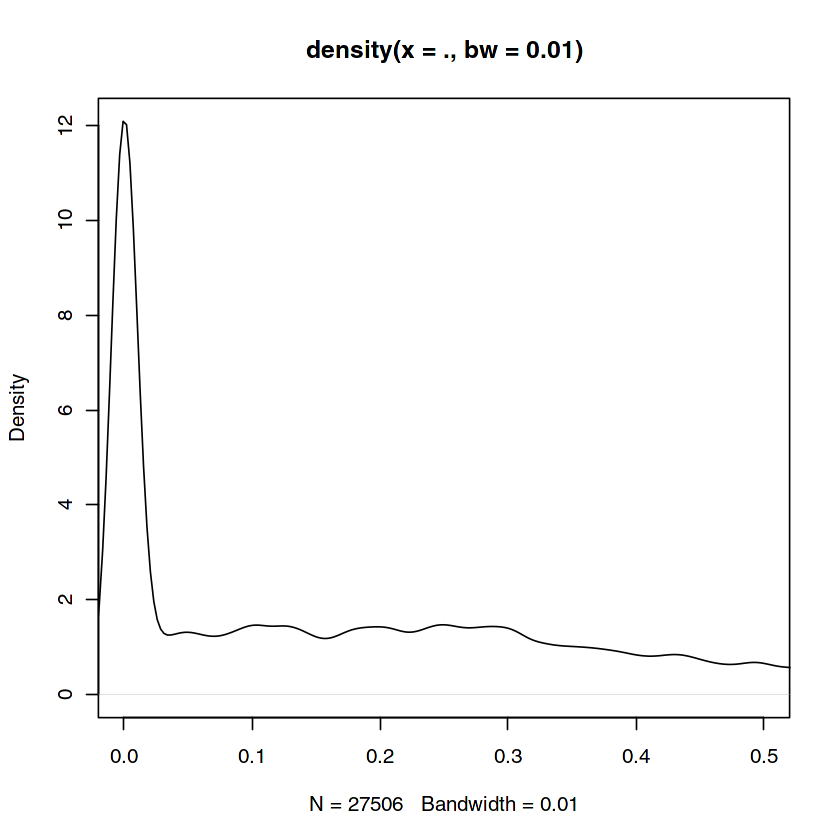

In [6]:
Test_Feature <- dplyr::select(windows, matches("Early|Late")) %>% print()
(rowMaxs(as.matrix(Test_Feature))) %>%
  density(bw = 0.01) %>%
  plot(xlim=c(0, 0.5))
Test_Feature <- tibble(Test_Feature, Other = pmax(0, 0.1 - rowSums(as.matrix(Test_Feature))))

In [7]:
Scale_Feature <- 1 / colMeans(Test_Feature >= 0.025)
windows$Peak <- colnames(Test_Feature)[
  apply(
    Test_Feature,
    1,
    \(v) which.max(v * Scale_Feature)
  )
]

In [8]:
write(deparse(unique(windows$Peak)), stdout())

c("Other", "Kc167_Early", "GSC_CySC_Early", "Static_Early", "CySC_Early", 
"Static_Late", "Kc167_Late", "GSC_CySC_Late", "GSC_Early")


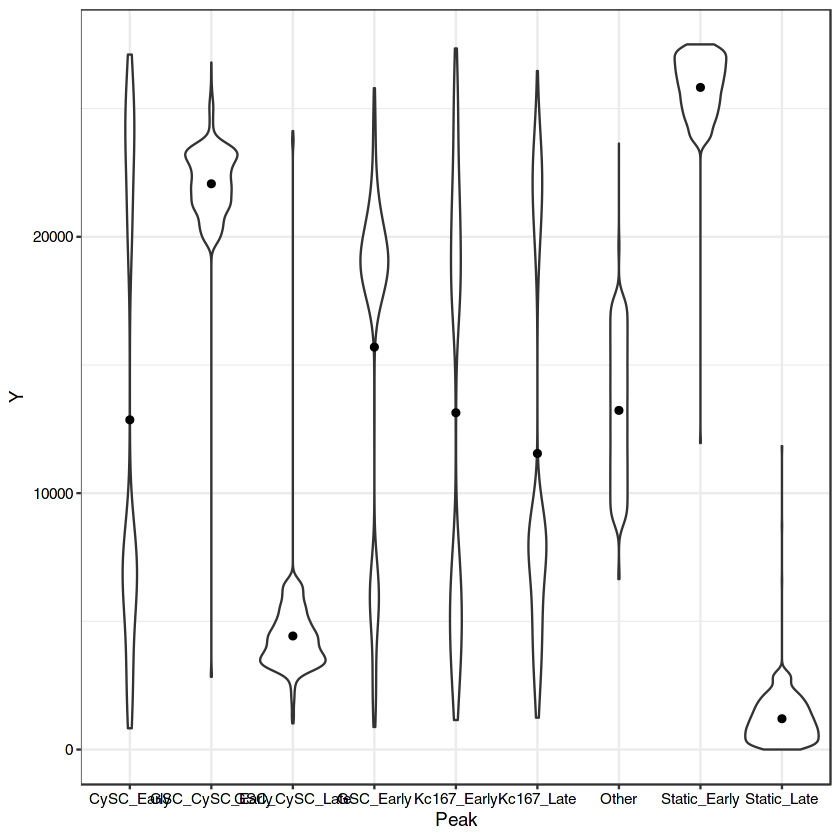

In [9]:
library(ggplot2)
# mult <- 1e2
library(withr)
# sortperm <- with(
#   windows,
#   order(
#     mult^4 * ((Static_Early - Static_Late) %>% replace(abs(.) < 0.02, 0)) +
#       mult^3 * ((GSC_CySC_Early - GSC_CySC_Late) %>% replace(abs(.) < 0.02, 0)) +
#       mult^2 * ((GSC_Early - CySC_Early) %>% replace(abs(.) < 0.02, 0)) +
#       mult * ((Kc167_Early - Kc167_Late) %>% replace(abs(.) < 0.02, 0)) +
#       Grand_Mean +
#       with_seed(0, runif(length(Static_Early), min=0, max=1e-10))
#   )
# )
cutoff <- 0.025
sortperm <- with(
  windows,
  order(
    ((Static_Early - Static_Late) %>% replace(abs(.) < cutoff, 0)),
      ((GSC_CySC_Early - GSC_CySC_Late) %>% replace(abs(.) < cutoff, 0)),
      ((GSC_Early - CySC_Early) %>% replace(abs(.) < cutoff, 0)),
      ((Kc167_Early - Kc167_Late) %>% replace(abs(.) < cutoff, 0)),
      Grand_Mean,
      with_seed(0, runif(length(Static_Early), min=0, max=1e-10))
  )
)
tibble(
  windows["Peak"],
  Y = order(sortperm)
) %>%
  ggplot(aes(Peak, Y)) +
  geom_violin() +
  geom_point(data = \(df) df %>% group_by(Peak) %>% summarise(across(Y, mean)))

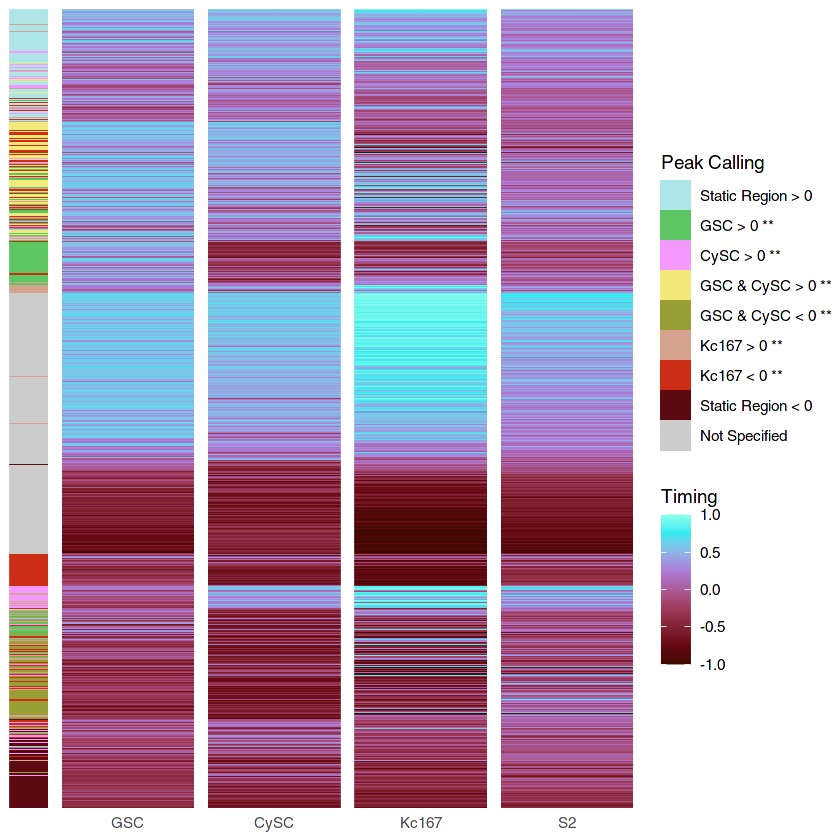

In [10]:
library(ggnewscale)
library(ggplot2)
library(reshape2)
Classification_Color <- c(
  Static_Early = "#aee5e7",
  GSC_Early = "#5DC663",
  CySC_Early = "#f598ff",
  GSC_CySC_Early = "#f3e97a",
  GSC_CySC_Late = "#999e36",
  Kc167_Early = "#d5a28d",
  Kc167_Late = "#cc2d15",
  Static_Late = "#5c0912",
  Other = "#cccccc"
)
Classification_Label <- c(
  Static_Early = "Static Region > 0",
  GSC_Early = "GSC > 0 **",
  CySC_Early = "CySC > 0 **",
  GSC_CySC_Early = "GSC & CySC > 0 **",
  GSC_CySC_Late = "GSC & CySC < 0 **",
  Kc167_Early = "Kc167 > 0 **",
  Kc167_Late = "Kc167 < 0 **",
  Static_Late = "Static Region < 0",
  Other = "Not Specified"
)
xs <- 1 + 1.1 * seq(0, 4)
width <- unit(4, "in")
height <- unit(4, "in")
strip_width <- unit(0.25, "in")
# Solve this:
# W / (R + W) = strip_width / width
# -> W = strip_width / width * (R + W)
# -> (1 - strip_width / width) * W = strip_width / width * R
# -> W = strip_width / width * R / (1 - strip_width / width)
# where R (the right-side) is max(xs) - min(xs)
strip_width_plot_units <- as.numeric(strip_width) / as.numeric(width) *
  (max(xs) - min(xs)) /
  (1 - as.numeric(strip_width) / as.numeric(width))
xlim <- c(1.5 - strip_width_plot_units, max(xs) + 0.5)
M <- as.matrix(windows[sortperm, c("GSC", "CySC", "Kc167", "S2")])
p <- ggplot(
  melt(M) %>% tibble(x = xs[1 + as.numeric(Var2)]),
  aes(x, Var1)
) +
  geom_raster(aes(fill = Peak), tibble(x = xs[1], Var1 = seq_along(windows$Peak), Peak = factor(windows$Peak[sortperm], names(Classification_Color)))) +
  scale_fill_manual(
    values = Classification_Color,
    labels = Classification_Label,
    guide = guide_legend("Peak Calling")
  ) +
  new_scale_fill() +
  geom_raster(aes(fill = value), \(df) df %>% subset(x == xs[2])) +
  geom_raster(aes(fill = value), \(df) df %>% subset(x == xs[3])) +
  geom_raster(aes(fill = value), \(df) df %>% subset(x == xs[4])) +
  geom_raster(aes(fill = value), \(df) df %>% subset(x == xs[5])) +
  scale_x_continuous(
    breaks = xs[-1],
    labels = colnames(M),
    minor_breaks = NULL
  ) +
  scale_y_continuous(breaks = NULL, minor_breaks = NULL) +
  scale_fill_gradientn(
      colors = c(
        hcl(30, 40, 10),
        repli_level_colors$L,
        repli_level_colors$ML,
        repli_level_colors$EM,
        repli_level_colors$E,
        hcl(170, 55, 95)
      ),
      values = c(0, 0.125, 0.375, 0.625, 0.875, 1),
      guide = guide_colorbar(title = "Timing"),
      limits = c(-1, 1)
    ) +
  coord_cartesian(xlim, expand = F) +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(
    legend.key.size = strip_width
  )
p


In [11]:
windows$Peak_Ordered <- windows$Peak %>%
  replace(
    . == "Other",
    ifelse(
      windows$Grand_Mean[. == "Other"] > 0,
      "Other>",
      "Other<"
    )
  )
windows[c("Peak_Ordered", "GSC", "CySC", "Kc167", "S2")] %>%
  group_by(Peak_Ordered) %>%
  summarise_all(mean) %>%
  arrange(rowMeans(cbind(GSC, CySC, Kc167, S2)))
sortperm <- order(
  factor(
    windows$Peak_Ordered,
    c(
      "Other<",
      "Static_Late",
      "Kc167_Late",
      "GSC_CySC_Late",
      "CySC_Early",
      "Kc167_Early",
      "GSC_Early",
      "GSC_CySC_Early",
      "Static_Early",
      "Other>"
    )
  ),
  order(sortperm)
)

Peak_Ordered,GSC,CySC,Kc167,S2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Other<,-0.47846097,-0.48817473,-0.68894567,-0.52757752
GSC_CySC_Late,-0.36316113,-0.54132029,-0.40448413,-0.11849717
Static_Late,-0.25260697,-0.34629669,-0.38776577,-0.17425797
Kc167_Late,-0.07310379,-0.17399324,-0.54510856,-0.08213057
GSC_Early,0.37659757,-0.29551577,-0.06551218,-0.03059964
CySC_Early,-0.18525126,0.31491560,0.10300186,0.16341213
Kc167_Early,-0.01754361,0.02186715,0.52414671,0.07924598
Static_Early,0.30207369,0.32669900,0.26794147,0.21429310
GSC_CySC_Early,0.52530852,0.44996273,0.30189485,0.10380628


In [50]:
M <- as.matrix(windows[sortperm, c("GSC", "CySC", "Kc167", "S2")])
margin_size <- width * 0.1 / (max(xs) + 0.5 - min(xs) - 0.5)
# Determine how much space in vertical plot units to add between the regions.
# This could be similar to calculating the strip_width provided width of the
# keys given that when we allocate the amount of the x coordinates to the strip,
# then that changes the scale that the x coordinates is on (it is a rational
# function, not a matter of scaling it up). However, here we are going to determine
# a margin in y coordinates, how to make it comparable to the margin of 0.1 in x
# coordinates, and not consider how when we add 9 of these y margins then the height
# of the graphic will change in y coordinates.
plot_y_gap <- round(as.numeric(margin_size) / as.numeric(height) * length(sortperm))
plot_y <- seq(nrow(M)) +
  plot_y_gap *
  cumsum(
    c(
      0,
      windows$Peak_Ordered[sortperm[-1]] != windows$Peak_Ordered[sortperm[-length(sortperm)]]
    )
  )

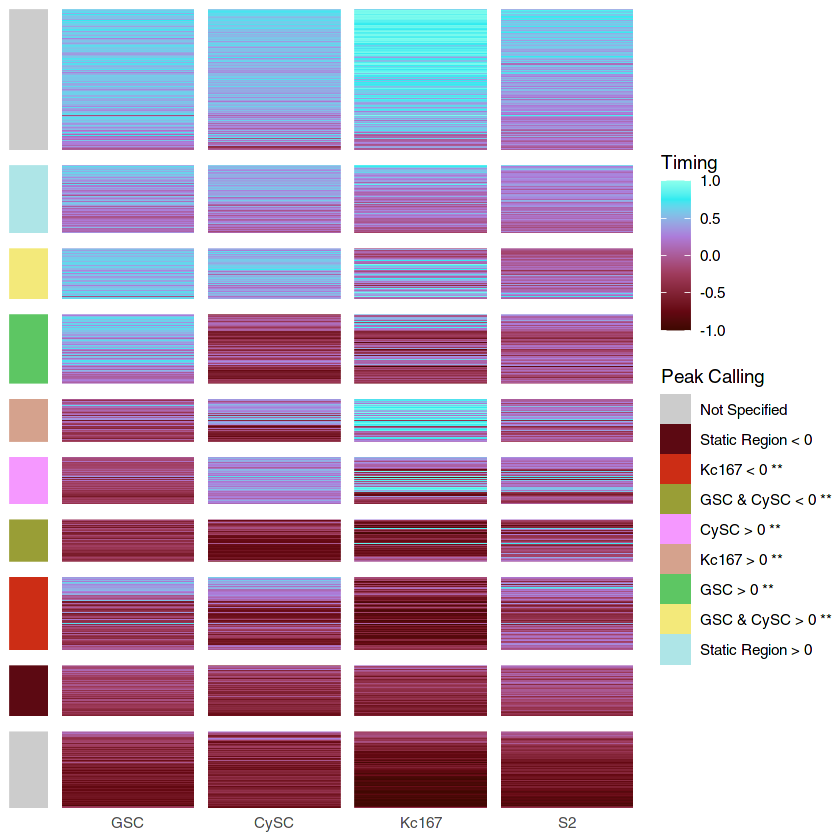

In [51]:
library(ggnewscale)
library(ggplot2)
library(reshape2)
Classification_Color <- c(
  Static_Early = "#aee5e7",
  GSC_Early = "#5DC663",
  CySC_Early = "#f598ff",
  GSC_CySC_Early = "#f3e97a",
  GSC_CySC_Late = "#999e36",
  Kc167_Early = "#d5a28d",
  Kc167_Late = "#cc2d15",
  Static_Late = "#5c0912",
  Other = "#cccccc"
)
Classification_Label <- c(
  Static_Early = "Static Region > 0",
  GSC_Early = "GSC > 0 **",
  CySC_Early = "CySC > 0 **",
  GSC_CySC_Early = "GSC & CySC > 0 **",
  GSC_CySC_Late = "GSC & CySC < 0 **",
  Kc167_Early = "Kc167 > 0 **",
  Kc167_Late = "Kc167 < 0 **",
  Static_Late = "Static Region < 0",
  Other = "Not Specified"
)
xs <- 1 + 1.1 * seq(0, 4)
width <- unit(4, "in")
height <- unit(4, "in")
strip_width <- unit(0.25, "in")
# Solve this:
# W / (R + W) = strip_width / width
# -> W = strip_width / width * (R + W)
# -> (1 - strip_width / width) * W = strip_width / width * R
# -> W = strip_width / width * R / (1 - strip_width / width)
# where R (the right-side) is max(xs) - min(xs)
strip_width_plot_units <- as.numeric(strip_width) / as.numeric(width) *
  (max(xs) - min(xs)) /
  (1 - as.numeric(strip_width) / as.numeric(width))
xlim <- c(1.5 - strip_width_plot_units, max(xs) + 0.5)
M <- as.matrix(windows[sortperm, c("GSC", "CySC", "Kc167", "S2")])
p2 <- ggplot(
  melt(M) %>% tibble(x = xs[1 + as.numeric(Var2)]),
  aes(x, Var1)
)
for (slice_name in unique(windows$Peak_Ordered[sortperm])) {
  p2 <- p2 +
    geom_raster(aes(fill = Peak), tibble(x = xs[1], Var1 = plot_y[seq_along(windows$Peak)], Peak = factor(windows$Peak[sortperm], names(Classification_Color))) %>% subset(windows$Peak_Ordered[sortperm] == slice_name))
}
p2 <- p2 +
  scale_fill_manual(
    values = Classification_Color,
    labels = Classification_Label,
    guide = guide_legend("Peak Calling")
  ) +
  new_scale_fill()
subset_slice <- function(xs, slice_name) {
  \(df) df %>% subset(x == xs & windows$Peak_Ordered[sortperm][Var1] == slice_name) %>% mutate(Var1 = plot_y[Var1])
}
for (slice_name in unique(windows$Peak_Ordered[sortperm])) {
  p2 <- p2 +
    geom_raster(aes(fill = value), do.call(subset_slice, list(xs[2], slice_name))) +
    geom_raster(aes(fill = value), do.call(subset_slice, list(xs[3], slice_name))) +
    geom_raster(aes(fill = value), do.call(subset_slice, list(xs[4], slice_name))) +
    geom_raster(aes(fill = value), do.call(subset_slice, list(xs[5], slice_name)))
}
p2 <- p2 +
  scale_x_continuous(
    breaks = xs[-1],
    labels = colnames(M),
    minor_breaks = NULL
  ) +
  scale_y_continuous(breaks = NULL, minor_breaks = NULL) +
  scale_fill_gradientn(
      colors = c(
        hcl(30, 40, 10),
        repli_level_colors$L,
        repli_level_colors$ML,
        repli_level_colors$EM,
        repli_level_colors$E,
        hcl(170, 55, 95)
      ),
      values = c(0, 0.125, 0.375, 0.625, 0.875, 1),
      guide = guide_colorbar(title = "Timing"),
      limits = c(-1, 1)
    ) +
  coord_cartesian(xlim, expand = F) +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(
    legend.key.size = strip_width,
    panel.grid.major.x = element_blank(),
  )
p2


In [52]:
length(p2$layers)

[1] 50

In [53]:
table(windows$Peak)


    CySC_Early GSC_CySC_Early  GSC_CySC_Late      GSC_Early    Kc167_Early 
          1965           2109           1752           2875           1792 
    Kc167_Late          Other   Static_Early    Static_Late 
          3046           9028           2823           2116 

In [54]:
matrix(
  c(
    1, 0, 0, 1, 0, 0, 0, 0, 0,
    0, 1, 1, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 1, 1, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 1, 1,
    0, 0, 0, 0, 0, 0, 1, 0, 0
  ),
  nrow = 5,
  byrow = TRUE,
  dimnames = list(
    c("GSC", "Stem-vs-Embryo", "Kc167", "Static", "Not Specified"),
    NULL
  )
) %*%
  table(windows$Peak) %>%
  as.data.frame() %>%
  rownames_to_column() %>%
  mutate(V1 = V1 / nrow(windows))

rowname,V1
<chr>,<dbl>
GSC,0.1759616
Stem-vs-Embryo,0.1403694
Kc167,0.1758889
Static,0.1795608
Not Specified,0.3282193


In [55]:
windows[
  windows$Peak %in% c("GSC_Early", "CySC_Early"),
  8:11
] %>%
  t() %>%
  dist()

           GSC     CySC    Kc167
CySC  44.34845                  
Kc167 37.94129 30.69051         
S2    32.82942 25.38633 21.78276

In [56]:
windows[
  !(windows$Peak %in% c("GSC_Early", "CySC_Early")),
  8:11
] %>%
  t() %>%
  dist()

           GSC     CySC    Kc167
CySC  41.05485                  
Kc167 55.55321 58.29326         
S2    44.51463 50.25476 53.89408

In [57]:
windows[
  windows$Peak %in% c("GSC_Early", "CySC_Early"),
  8:11
] %>%
  t() %>%
  dist()

           GSC     CySC    Kc167
CySC  44.34845                  
Kc167 37.94129 30.69051         
S2    32.82942 25.38633 21.78276

# Recapitulate Colv

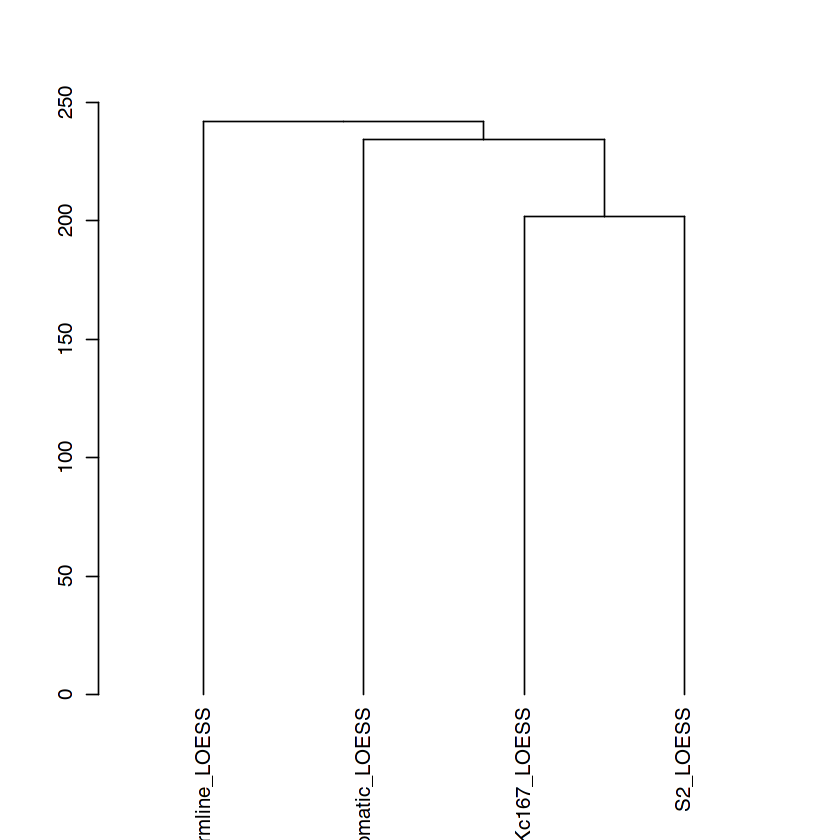

In [58]:
library(dplyr)
library(GenomicRanges)
library(targets)
source("_targets.R")
tar_load(chic.tile.diameter_1000_chr)
tar_load(matches("repli.timing_.*chr$"))
tar_load(chromosome_pericetromere_label)

Y <- tibble(
  chr = names(chr.lengths),
  xmin = 2500,
  xmax = floor((chr.lengths - 2500) / 5000) * 5000,
  Germline = list(repli.timing_Germline_chr),
  Somatic = list(repli.timing_Somatic_chr),
  Kc167 = list(repli.timing_Kc167_chr),
  S2 = list(repli.timing_S2_chr),
) %>%
  group_by(chr, xmin, xmax) %>%
  reframe(
    x = seq(xmin, xmax, by = 5000),
    region = (
      as.character(chr) %>%
        paste0(
          replace(
            rep("", length(x)),
            chromosome_pericetromere_label %>%
              findOverlaps(
                GRanges(
                  chr,
                  IRanges(x, width=1),
                  seqlengths = seqlengths(repli.timing_Germline_chr)
                )
              ) %>%
              to(),
            "C"
          )
        ) %>%
      factor(
        c("2L", "2LC", "2RC", "2R", "3L", "3LC", "3RC", "3R", "4", "X", "Y", "rDNA")
      )
    ),
    across(
      !matches("^(x|region)$"),
      list(
        LOESS = ~ (
          loess(
            y.track ~ x.track,
            tibble(
              x.track = .x[[1]][seqnames(.x[[1]]) == chr] %>% mid(),
              y.track = .x[[1]][seqnames(.x[[1]]) == chr]$score,
            ),
            span = 0.025
          ) %>%
          predict(tibble(x.track = x))
        )
      )
    )
  ) %>%
  subset(select = -c(xmin, xmax))
YMEAN <- Y %>%
  group_by(region) %>%
  summarise(across(matches("LOESS"), mean))

YS <- Y[
  c("Germline_LOESS", "Somatic_LOESS", "Kc167_LOESS", "S2_LOESS")
] %>%
  as.matrix() %>%
  scale() %>%
  t() %>%
  scale() %>%
  t()
YS[Y$chr == "Y", ] <- (
  YS[Y$chr == "Y", c(1, 2, 4)] %>%
    t() %>%
    scale() %>%
    t() %>%
    `%*%`(
      matrix(
        c(
          1, 0, 0,
          0, 1, 0,
          0, 0, 0,
          0, 0, 1
        ),
        nrow = 3,
        dimnames = list(
          NULL,
          colnames(Y)[4:7]
        )
      )
    )
)

Colv <- as.dendrogram(hclust(dist(t(YS)), "average"))
plot(Colv)

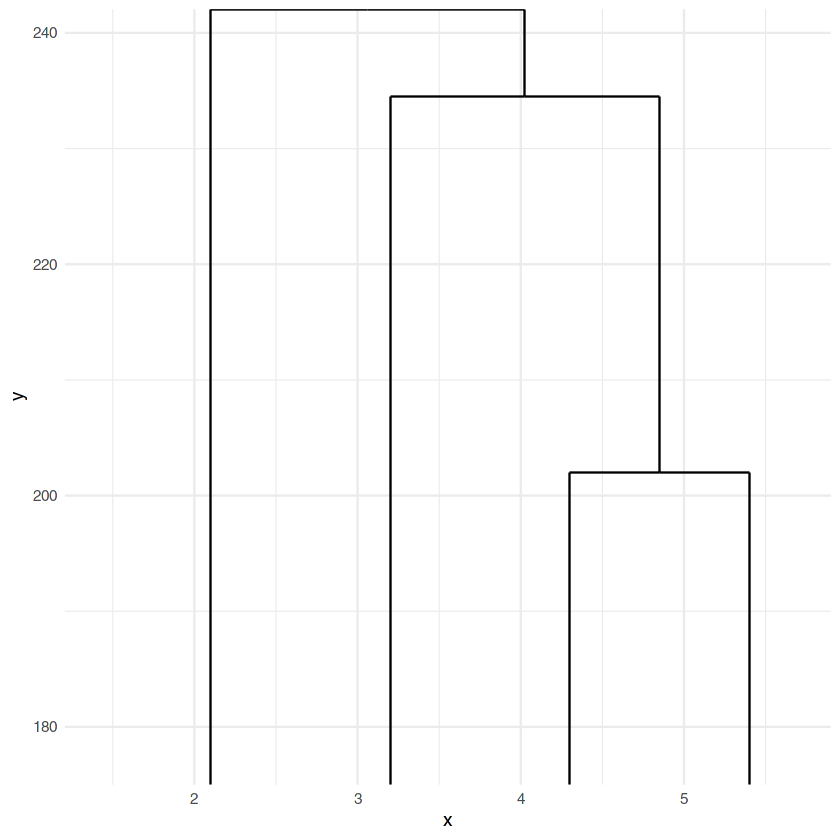

In [59]:
library(ggdendro)

ColPlot <- Colv
i <- 1
ColPlot[[i]] <- ColPlot[[i]] %>% `attr<-`("height", value = 175)
i <- c(2, 1)
ColPlot[[i]] <- ColPlot[[i]] %>% `attr<-`("height", value = 175)
i <- c(2, 2, 1)
ColPlot[[i]] <- ColPlot[[i]] %>% `attr<-`("height", value = 175)
i <- c(2, 2, 2)
ColPlot[[i]] <- ColPlot[[i]] %>% `attr<-`("height", value = 175)
Y_Margin <- segment(dendro_data(ColPlot, type = "rectangle")) %>%
  mutate(
    across(
      c(x, xend),
      \(v) (v - 1) * diff(head(xs, 2)) + xs[2]
    )
  ) %>%
  ggplot(aes(x, y, xend = xend, yend = yend)) +
  geom_segment() +
  coord_cartesian(xlim, NULL, ex=F) +
  theme_void()
Y_Margin + theme_minimal()

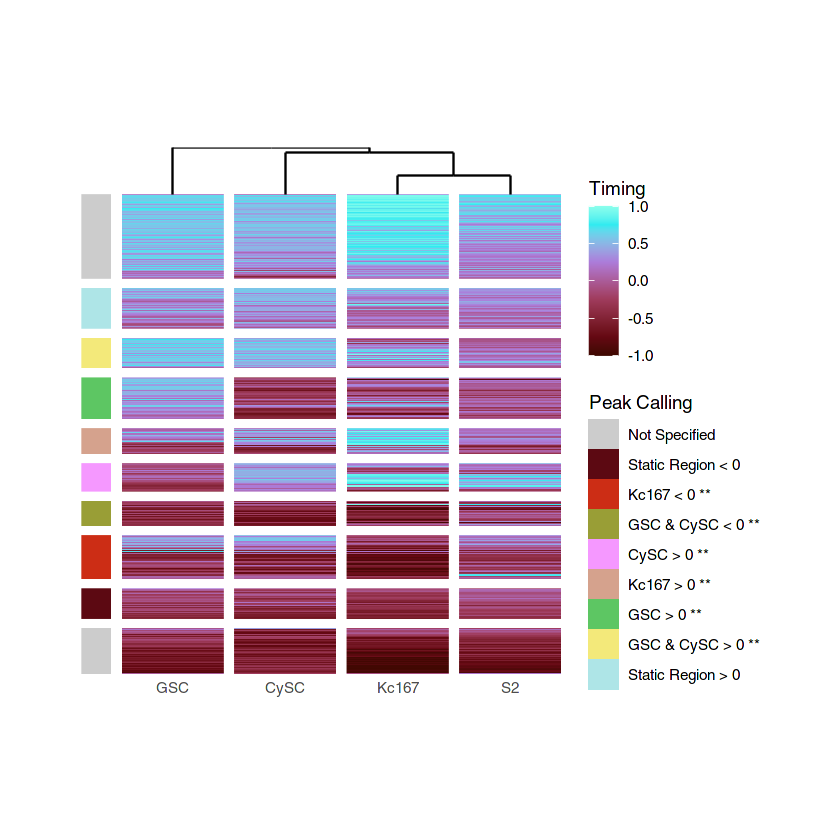

In [60]:
library(egg)
library(grid)
library(gtable)
grob <- set_panel_size(p2, w = width, h=height)
grob$heights[1] <- unit(0.5, "in")
grob <- grob %>%
  gtable_add_grob(
    list(ggplotGrob(Y_Margin + theme(plot.margin = margin(8, 0, 0, 0)))),
    t = 1,
    l = grob$layout$l[match("panel", grob$layout$name)]
  )
grid.draw(grob)

In [61]:
ggsave("illustrations/Repli-Heatmap.pdf", grob, w=6, h=6)